In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR

import matplotlib.pyplot as plt
import time
import numpy as np

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

from ph3 import *
import os
import torch.optim as optim
import torch
import pickle


In [3]:
if torch.cuda.is_available:
  print('Good to go!')
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go!


In [4]:
# Configuration
image_size = (112, 112)
data_paht = "./dataset/archive/images"
captions_path = "./dataset/archive/captions.txt"
data_dict_path = "./dataset/image_captioning_dataset.pt"

data_dict = load_data(data_dict_path, captions_path, data_paht, image_size)

/home/mahdi/Documents/term8/CI_CNNProject_Fall2024/Phase-3/ph3.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load(file_path)


Dataset loaded successfully.


In [5]:
num_train = len(data_dict['train_images'])
num_val = len(data_dict['val_images'])
print(f'num_train: {num_train}')
print(f'num_val: {num_val}')

num_train: 6472
num_val: 1619


In [6]:
data_dict['train_images'].shape

torch.Size([6472, 3, 112, 112])

In [7]:
data_dict['train_captions'].shape

torch.Size([6472, 5, 40])

In [8]:
len(data_dict["vocab"]["idx_to_token"])

8908

We have 6,472 lists of captions. 

- Each list contains 5 captions.  
- Each caption consists of 40 tokens (with padding).  
- Each token is represented as a vector of size 8,908 (one-hot encoding).  


In [9]:
PAD_index = 0

`start = 1`,
`end = 2`,
`pad = 0`

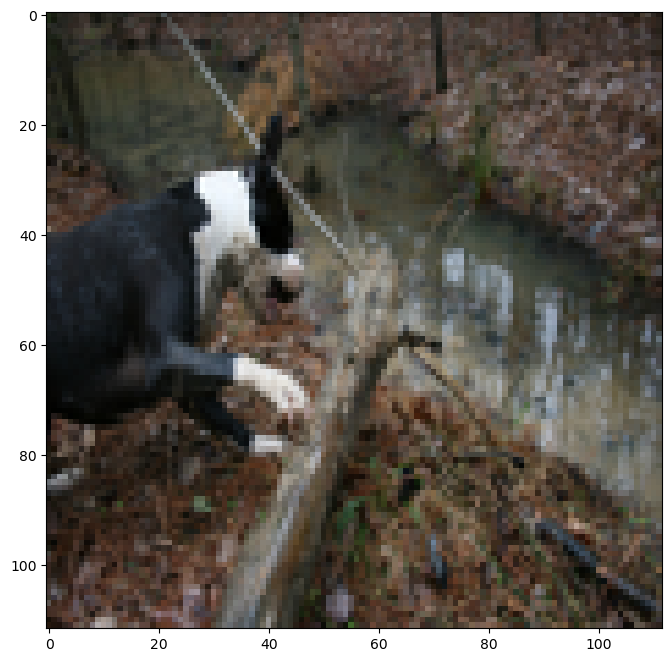

In [10]:
plt.imshow(data_dict['train_images'][0].permute(1, 2, 0))

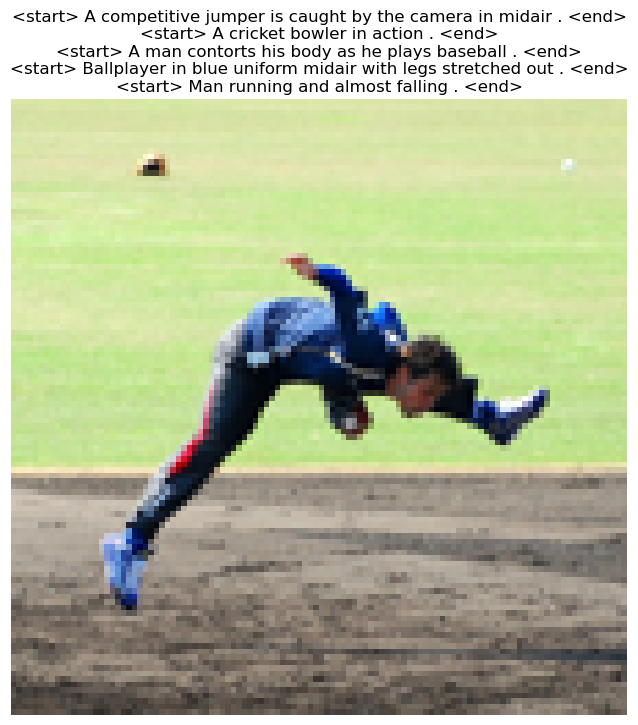

In [11]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 1

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  caption_str = "\n".join(caption_str)
  plt.title(caption_str)
  plt.show()

### RNN

In [12]:
# create the image captioning model
rnn_model = CaptioningRNN(
          cell_type='lstm',
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, 
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=PAD_index,
          **to_float_cuda)

In [13]:
lr = 1e-2
epochs = 10
lr_decay = 1
batch_size=256

# Model and file paths
name = 'rnn'
version = 1
checkpoint_path = f'./checkpoint/{name}_{version}_checkpoint.pth'
model_path = f'./models/{name}_{version}_checkpoint.pth'
history_path = f'./history/{name}_{version}.pth'

if os.path.exists(checkpoint_path):
    # Resume training from checkpoint
    print(f"Resuming training from checkpoint: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)
    model = rnn_model.to(device)
    model.load_state_dict(checkpoint['model_state'])

    optimizer = optim.Adam(model.parameters(), lr=lr)

    optimizer.load_state_dict(checkpoint['optimizer_state'])

    # scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    if checkpoint['scheduler_state'] is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state'])

    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    train_metrics_history = checkpoint['train_history']
    val_metrics_history = checkpoint['val_history']
    lr_history = checkpoint['lr_history']

    print(f"Training will resume from epoch {start_epoch}.\n")

else:
    # Start new training
    print(f"Training new model: {name}\n")

    # Initialize model and optimizer
    model = rnn_model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # optimizer = optim.SGD(model.fc.parameters(), min_lr)

    # Define scheduler
    # scheduler = optim.lr_scheduler.LambdaLR(optimizer,lambda epoch: lr_decay ** epoch)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    # Initialize metrics and state
    start_epoch = 0
    best_val_acc = 0.0
    train_metrics_history = {'loss': [], 'accuracy': [],
                             'precision': [], 'recall': [], 'f1': []}
    val_metrics_history = {'accuracy': [],
                           'precision': [], 'recall': [], 'f1': []}
    lr_history = []

# Train model
train_loss_history, val_loss_history = train_captioning_model(
    rnn_model, optimizer, data_dict, device='cuda', dtype=torch.float32,
    epochs=epochs, batch_size=batch_size, scheduler=None, val_perc=0.5,
    verbose=True
)

# Save final model and history after training completes
torch.save(model.state_dict(), model_path)
print(f"Final model saved at: {model_path}")

with open(history_path, 'wb') as f:
    pickle.dump((train_loss_history, val_loss_history), f)
print(f"Training history saved at: {history_path}")



Training new model: rnn

Epoch 1/10
  Batch 1/25, Loss = 76.1944
  Batch 11/25, Loss = 46.8200
  Batch 21/25, Loss = 44.3583
  Training Loss: 50.8186
  Validation Loss: 1.3076
Epoch 2/10
  Batch 1/25, Loss = 43.1209
  Batch 11/25, Loss = 38.3571
  Batch 21/25, Loss = 38.2233
  Training Loss: 39.0326
  Validation Loss: 1.2593
Epoch 3/10
  Batch 1/25, Loss = 37.8138
  Batch 11/25, Loss = 34.6530
  Batch 21/25, Loss = 34.8157
  Training Loss: 35.2152
  Validation Loss: 1.2633
Epoch 4/10
  Batch 1/25, Loss = 34.5157
  Batch 11/25, Loss = 32.0660
  Batch 21/25, Loss = 32.6512
  Training Loss: 32.6464
  Validation Loss: 1.2838
Epoch 5/10
  Batch 1/25, Loss = 32.2349
  Batch 11/25, Loss = 29.8902
  Batch 21/25, Loss = 30.9166
  Training Loss: 30.7317
  Validation Loss: 1.3109
Epoch 6/10
  Batch 1/25, Loss = 30.7136
  Batch 11/25, Loss = 28.3175
  Batch 21/25, Loss = 29.5223
  Training Loss: 29.2235
  Validation Loss: 1.3369
Epoch 7/10
  Batch 1/25, Loss = 29.4841
  Batch 11/25, Loss = 27.1006